Téléchargement de la base

In [1]:
!wget https://www.dropbox.com/s/sbiotru4wlr3ykj/train.csv.zip?dl=0 -O train.csv.zip

!unzip train.csv.zip

--2021-04-18 09:28:11--  https://www.dropbox.com/s/sbiotru4wlr3ykj/train.csv.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/sbiotru4wlr3ykj/train.csv.zip [following]
--2021-04-18 09:28:11--  https://www.dropbox.com/s/raw/sbiotru4wlr3ykj/train.csv.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc28b8d8754f9a1f43b974bba4bb.dl.dropboxusercontent.com/cd/0/inline/BM1t3cTcgfpC2d2azFU4AnF6cgOoyX2d0ECGshMxb7B3yOJW6MHK77x52QL_9M6k9cBgIAJQ4XLliBfWBU7PdTFKKfQw3JaATEjQsAXO_eXrziEF597smTGTNy_nWxKEBmTjsSQDsjVDjrcluDxzbqAR/file# [following]
--2021-04-18 09:28:11--  https://uc28b8d8754f9a1f43b974bba4bb.dl.dropboxusercontent.com/cd/0/inline/BM1t3cTcgfpC2d2azFU4AnF6cgOoyX2d0ECGshMxb7B3yOJW6MHK77x52QL_9M6k9cBgIAJQ4XLliBfWBU

Imports

In [2]:
!pip install transformers

     |████████████████████████████████| 2.1MB 16.5MB/s 
     |████████████████████████████████| 3.3MB 43.7MB/s 
     |████████████████████████████████| 870kB 49.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=a63b50980b5809735e8311d193bc3549869152277552553f0d704ef3f0a04a75
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses


In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from transformers import BertTokenizer, AutoModel, AutoTokenizer
import pandas as pd
from torch.utils.data import DataLoader

if torch.cuda.is_available():    
    print("Using GPU")
    device = torch.device("cuda")

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

Using GPU


## Présentation de la base

In [4]:
df = pd.read_csv('train.csv')
df.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:41.987077+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:42.870083+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:45.222647+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:47.601894+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015-09-29 10:50:48.488476+00,2,NaN,2006,rejected,0,0,0,1,0,0.0,4,47


Class imbalance :

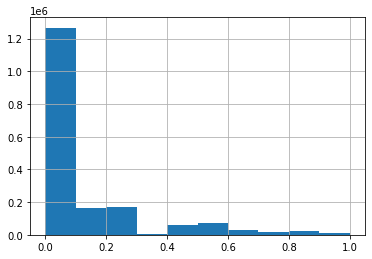

In [5]:
df['target'].hist()

D'apres kaggle, la baseline est "mauvais commentaire $\Leftrightarrow$ toxic $\ge$ 0.5", donc grosse class unbalance

La base est giganteque donc pour les premiers essais je garde que les phrases de toxitié non nulle et j'en prends 10.000

In [11]:
pd.concat([df[0:10], df[10:20]])

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:41.987077+00,2,NaN,2006,rejected,0,0,0,0,0,0.000000,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:42.870083+00,2,NaN,2006,rejected,0,0,0,0,0,0.000000,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:45.222647+00,2,NaN,2006,rejected,0,0,0,0,0,0.000000,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:47.601894+00,2,NaN,2006,rejected,0,0,0,0,0,0.000000,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.000000,0.021277,0.872340,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015-09-29 10:50:48.488476+00,2,NaN,2006,rejected,0,0,0,1,0,0.000000,4,47
5,59859,0.666667,ur a sh*tty comment.,0.047619,0.638095,0.000000,0.333333,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:50.865549+00,2,NaN,2006,rejected,0,0,0,0,0,0.009524,0,105
6,59861,0.457627,hahahahahahahahhha suck it.,0.050847,0.305085,0.000000,0.254237,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:52.451277+00,2,NaN,2006,rejected,0,0,0,0,0,0.220339,0,59
7,59863,0.000000,FFFFUUUUUUUUUUUUUUU,0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:54.055221+00,2,NaN,2006,rejected,0,0,0,0,0,0.000000,0,4
8,239575,0.000000,The ranchers seem motivated by mostly by greed...,0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-13 18:01:05.156229+00,6,NaN,26662,approved,0,0,0,0,0,0.000000,0,4
9,239576,0.000000,It was a great show. Not a combo I'd of expect...,0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-13 18:11:21.570460+00,6,239522.0,26650,approved,0,0,0,1,0,0.000000,0,4


In [12]:
# n = nombre de phrases a prendre (trop long pour faire les tests)
df = pd.concat([df[df['target'] > 0].sample(n=10000), df[df['target'] == 0].sample(n=2000)]).sample(frac=1)

In [13]:
sentences = df.comment_text.values
labels = df.target.values

Preprocessing des phrases

In [14]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Tokenisation selon les normes de BERT (avec l'option add_special_tokens qui met les BOS/EOS) 

In [15]:
inputs = []
from tqdm import tqdm
for sentence in tqdm(sentences, position=0):
    encoded_sent = tokenizer.encode(sentence,                  
                                    add_special_tokens = True, 
                                    )
    
    inputs.append(encoded_sent)

100%|██████████| 12000/12000 [00:16<00:00, 724.35it/s]


In [16]:
print('Max sentence length: ', max([len(sen) for sen in inputs]))

Max sentence length:  310


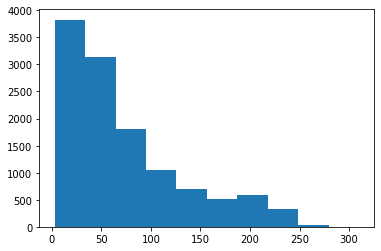

In [17]:
from matplotlib import pyplot as plt
sizes = [len(sen) for sen in inputs]
plt.hist(sizes);

In [20]:
import numpy as np
inputs_idx = np.argwhere(np.array(sizes) <= 64)
clean_inputs = []
clean_labels = []

for i, input in enumerate(inputs):
    if sizes[i] <= 64:
        clean_inputs.append(input)
        clean_labels.append(labels[i])

In [21]:
print('Max sentence length: ', max([len(sen) for sen in clean_inputs]))

Max sentence length:  64


In [22]:
from keras.preprocessing.sequence import pad_sequences

MAX_LEN = 64

clean_inputs = pad_sequences(clean_inputs, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")


Padding/truncating all sentences to 64 values...
\Done.


In [23]:
attention_masks = []

for sent in clean_inputs:    
    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]
    
    attention_masks.append(att_mask)

In [24]:
from sklearn.model_selection import train_test_split
# Use 80% for training and 20% for validation.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(clean_inputs, clean_labels, 
                                                            random_state=2021, test_size=0.2)
# Do the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, clean_labels,
                                             random_state=2021, test_size=0.2)

In [25]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [57]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 32

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [58]:
import torch.nn.functional as F

class ToxicPredictor(nn.Module):

    def __init__(self, pretrained_model_name='bert-base-uncased'):
        super(ToxicPredictor, self).__init__()
        
        #Loading Mask Language Model 
        self.encoder = AutoModel.from_pretrained(pretrained_model_name)

        #we append an extra layer for predicting toxicity (it will be randomly initialized)
        #self.fc1 = nn.Linear(self.encoder.pooler.dense.out_features, 100)
        self.fc2 = nn.Linear(self.encoder.pooler.dense.out_features, 1)

    def forward(self, seq, attn_masks):
        '''
        Inputs:
            -seq : Tensor of shape [B, T] containing token ids of sequences
            -attn_masks : Tensor of shape [B, T] containing attention masks to be used to avoid contibution of PAD tokens
        '''

        #Feeding the input to BERT model to obtain contextualized representations
        # see in the hugging face doc what to input
        #cont_reps = #  self.encoder(..)..
        cont_reps = self.encoder(seq, attention_mask = attn_masks)
        #Obtaining the representation of [CLS] head
        pool = cont_reps["pooler_output"]

        #x = F.relu(self.fc1(pool))
        pred = torch.sigmoid(self.fc2(pool))

        return pred


In [59]:
import gc
del model
gc.collect()

17250

In [60]:
model = ToxicPredictor('bert-base-uncased').to(device)

In [ ]:
model.encoder.requires_grad_ = False

In [61]:
import torch.nn as nn
import torch.optim as optim
# define the loss and optimizer 
criterion = nn.BCELoss()
opti = optim.Adam(model.parameters(), lr = 1e-4)

In [30]:
!pip install livelossplot

In [31]:
from livelossplot import PlotLosses

In [62]:
def train(model, criterion, opti, train_loader, val_loader, epochs=1):
    liveloss = PlotLosses()
    for epoch in range(epochs):
        logs = {}
        
        model.train()
        tot_loss = 0
        for it, (seq, attn_masks, labels) in tqdm(enumerate(train_loader), position=0, total=len(train_loader)):
            #Clear gradients
            opti.zero_grad()  

            #Converting these to cuda tensors
            seq, attn_masks, labels = seq.to(device), attn_masks.to(device), labels.to(device)
            
            preds = model(seq, attn_masks).view(-1)

            #Computing loss
            loss = criterion(preds, labels.float())

            #Backpropagating the gradients
            loss.backward()
            tot_loss += loss.item()

            #Optimization step
            opti.step()

        logs['loss'] = tot_loss/len(train_loader.dataset)

        loss_val = 0
        model.eval()  
        for it, (seq, attn_masks, labels) in tqdm(enumerate(val_loader), position=0, total=len(val_loader)):                    
            seq, attn_masks, labels = seq.to(device), attn_masks.to(device), labels.to(device)
            #Obtaining the logits from the model
            preds_val = model(seq, attn_masks)
        
            loss = criterion(preds_val.view(-1), labels.float())
  
            loss_val += loss.item()
        logs['val_loss'] = loss_val/len(val_loader.dataset)

        liveloss.update(logs)
        liveloss.send()

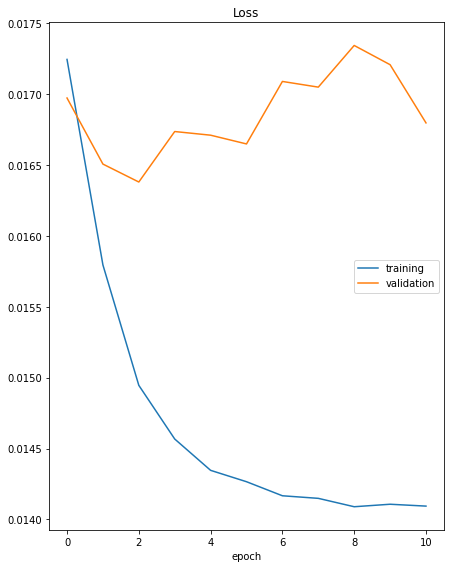

  0%|          | 0/175 [00:00<?, ?it/s]

Loss
	training         	 (min:    0.014, max:    0.017, cur:    0.014)
	validation       	 (min:    0.016, max:    0.017, cur:    0.017)


 11%|█▏        | 20/175 [00:07<00:57,  2.72it/s]

KeyboardInterrupt: ignored

In [63]:
train(model, criterion, opti, train_dataloader, validation_dataloader, epochs=20)